# Provider side

Our "Provider" is very good in recognizing MNIST images of digits 1-6. It doesn't "know" any other characters. it allows consumers to transfer the knowledge it has for recognizing new characters. The provider requires every consumer to pay 10 DOPA weis for every training cycle, and plans to charge 100 DOPA weis for every classification it later makes.

## Showing samples of characters known to provider

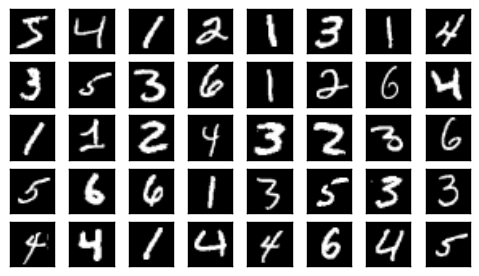

In [1]:
from digit_classifier import DigitClassifier
from mnist import MnistDataFiltered, plot_mnist
one_to_six = [1,2,3,4,5,6]
mnist_data = MnistDataFiltered(0,60000,one_to_six)
plot_mnist(mnist_data.x_train,40,8)

## Training a model based on about 36,000 1-6 caracters 

In [2]:
dc = DigitClassifier(one_to_six)
dc.build_graph()
dc.train(mnist_data.x_train, mnist_data.y_train, 15)
dc.freeze_first_layers()
dc.save('my_network2.ser')

## ImageClassifier Class

Our "ImageClassifier" is a learning service based on labels, derives from Dopamine's LabeledLearningServiceInstanceBase class. Basically, the code below does that while wrapping the Deep Learning model which is coded in [DigitClassifier](digit_classifier.py). It allows using a pre trained model, like the one prepared above:

In [3]:
from digit_classifier import DigitClassifier
from dopapy.core.services.instance.base.learning import LabeledLearningServiceInstanceBase
import dopapy.types as dt

class ImageClassifier(LabeledLearningServiceInstanceBase):
    def __init__(self, instance_id, pretrained_file):
        super().__init__(instance_id = instance_id)
        one_to_six = [1,2,3,4,5,6]
        self.digit_classifier = DigitClassifier(one_to_six)
        self.digit_classifier.build_graph()
        self.digit_classifier.load(pretrained_file)
        self.digit_classifier.freeze_first_layers()
        
    def train(self, update, return_gradient, data, labels):
        if return_gradient:
            raise InvalidArgumentException('return_gradient not supported')
        elif not update:
            raise InvalidArgumentException('not updating not supported')
        else:
            x_train, y_train = data[0], labels[0]
            print('Training...')
            self.digit_classifier.train(x_train.data, y_train.data, 1)        
            return y_train

    def predict(self, data):
        return dt.Tensor(self.digit_classifier.predict(data[0].data))

    def save_in_file(self, file_name):
        self.digit_classifier.save_in_file(file_name)

    def load_from_file(self, file_name):
        self.digit_classifier.load_from_file(file_name)


## ImageClassifier Instance Creator

In our example every consumer trains <B><U> its own </B></U> ImageClassifier, which is demonstrated in the following class. 

In [4]:
import dopapy
import dopapy.trading as dp
import dopapy.types as dt
from dopapy.utils.common.guid import GUID
from dopapy.core.services.instance.iservice import IServiceInstance, ILabeledLearningServiceInstance
from dopapy.core.services.instance.creator.icreator import IServiceInstanceCreator

class ImageClassifierInstanceCreator(IServiceInstanceCreator):
    def __init__(self, pretrained_file):
        self.instance_map = {}
        self.pretrained_file = pretrained_file
    def create_instance(self, service_instance_id: GUID):
        if service_instance_id not in self.instance_map:
            self.instance_map[service_instance_id] = ImageClassifier(instance_id=service_instance_id, pretrained_file=self.pretrained_file)
        if service_instance_id == dt.ServiceDescriptor.DEFAULT_SERVICE_INSTANCE_ID:
            raise InvalidArgumentException("This service does not support unique (non zero) instances")
        else:
            return self.instance_map[service_instance_id]

## Plugging the ImageClassifier onto the Dopamine Network

In [5]:
dopapy.init_logging()
import warnings
warnings.filterwarnings('ignore') #Thats just to ignore warnings that are irrelevant for this type of sample

session = dp.create_session(master_password='password123456',
                            keystore_dir='/data/dopamine/keystore_dir_b/',
                            web_server_host="127.0.0.1",
                            dopmn_budget=10000,  # Allow to spend DOPAs from this account
                            ether_budget=int(10E18),
                            web_server_port=8015)

my_service_descriptor = dt.ServiceDescriptor(
    service_role=dt.ServiceRole.PROVIDER,
    input_descriptors=[dt.TensorDescriptor([-1,28,28,1])],
    output_descriptors=[dt.TensorDescriptor([-1])],
    service_type=dt.ServiceType.Learning.LABELED
)

reward_desc = dp.create_reward_descriptor(min_dopamine_price=100)
reward_desc.add_payment(dt.RewardPaymentType.UPDATE, min_price=10)
reward_desc.add_payment(dt.RewardPaymentType.FORWARD, min_price=0)

my_instance_creator = ImageClassifierInstanceCreator(pretrained_file='my_network2.ser')

quote = dp.create_quote_services(
    service_instance_creator = my_instance_creator,
    session=session,
    service_descriptor=my_service_descriptor,
    side=dp.SELL,
    reward_descriptor=reward_desc)

quote.publish()

### Here provider needs to wait for the teachers to do their work...

<img src='../img/waiting.png'>

### Checking balance before servicing:

In [6]:
print('DOPA Balance:',session.wallet.dopmn_balance)
print('ETH  Balance:',session.wallet.ether_balance)

DOPA Balance: 1000000000033847
ETH  Balance: 3758869082135680000
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...
Training...

### Checking balance after teaching:

In [7]:
print('DOPA Balance:',session.wallet.dopmn_balance)
print('ETH  Balance:',session.wallet.ether_balance)

DOPA Balance: 1000000000022497
ETH  Balance: 3758869082135680000
